In [1]:
import os
import copy
import functools
import win32com.client

import lmfit
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import linregress, norm
from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity
from sivqed.models.fitter import cavity_ref_model, single_siv_ref_model, mcmc
from sivqed.models.fitter import single_siv_ref, two_siv_ref, cavity_ref, three_siv_ref
from sivqed.models.diffusion import diffused_siv_peaks, plot_diffused_contrasts

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [2]:
datafolder_path = win32com.client.Dispatch("WScript.Shell").CreateShortCut("../data.lnk").Targetpath
siv_path = datafolder_path + "/20210903_siv_linescan/"

# List of 2-tuples, first is the avg file (which contains the freq values), second is the scans file
siv_files = [["Edown_Ndown/linescan_down_down_low-readingtrace_x_18_01_33.txt", "Edown_Ndown/linescan_down_down_low-readingtracescans_18_01_33.txt"],  
             ["Edown_Ndown_overnight/linescan_downe_downn_low-readingtrace_x_10_37_06.txt", "Edown_Ndown_overnight/linescan_downe_downn_low-readingtracescans_10_37_06.txt"],
             ["Edown_Nup/linescan_downe_upn_low-readingtrace_x_20_49_32.txt", "Edown_Nup/linescan_downe_upn_low-readingtracescans_20_49_33.txt"],
             ["Eup_Ndown/linescan_upe_downn_low-readingtrace_x_22_45_37.txt", "Eup_Ndown/linescan_upe_downn_low-readingtracescans_22_45_38.txt"],
             ["Eup_Nup/linescan_upe_upn_low-readingtrace_x_23_49_04.txt", "Eup_Nup/linescan_upe_upn_low-readingtracescans_23_49_04.txt"]
            ]

# Plotting SiV

Edown_Ndown/linescan_down_down_low-readingtrace_x_18_01_33.txt
Edown_Ndown_overnight/linescan_downe_downn_low-readingtrace_x_10_37_06.txt
Edown_Nup/linescan_downe_upn_low-readingtrace_x_20_49_32.txt
Eup_Ndown/linescan_upe_downn_low-readingtrace_x_22_45_37.txt
Eup_Nup/linescan_upe_upn_low-readingtrace_x_23_49_04.txt


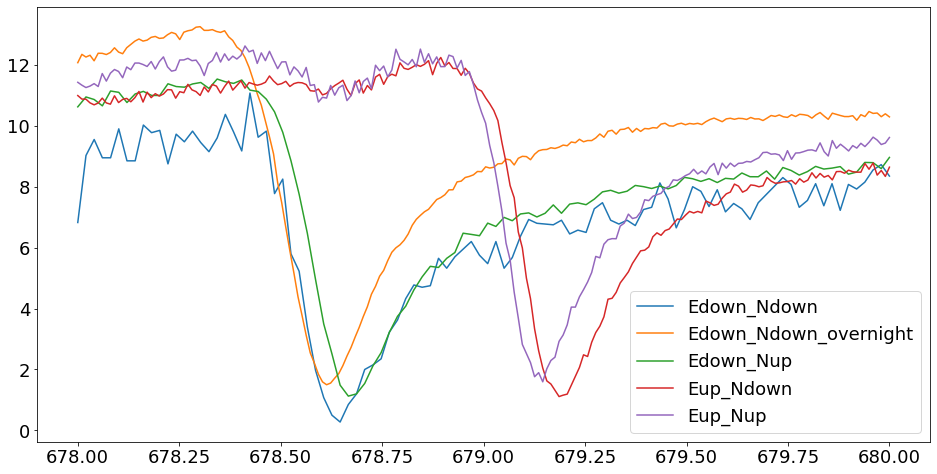

In [3]:
plt.figure(figsize=[16, 8])

for idx, scan_series in enumerate(siv_files):
    
    print(scan_series[0])
    
    siv_freqs = np.loadtxt(siv_path + scan_series[0])
    siv_intensity = np.loadtxt(siv_path + scan_series[1])
    siv_intensity_avg = np.mean(siv_intensity, axis=0)

    siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz

    plt.plot(siv_freqs, siv_intensity_avg, label=scan_series[0].split("/")[0])

plt.legend()

Edown_Ndown/linescan_down_down_low-readingtrace_x_18_01_33.txt
Edown_Ndown_overnight/linescan_downe_downn_low-readingtrace_x_10_37_06.txt
Edown_Nup/linescan_downe_upn_low-readingtrace_x_20_49_32.txt
Eup_Ndown/linescan_upe_downn_low-readingtrace_x_22_45_37.txt
Eup_Nup/linescan_upe_upn_low-readingtrace_x_23_49_04.txt


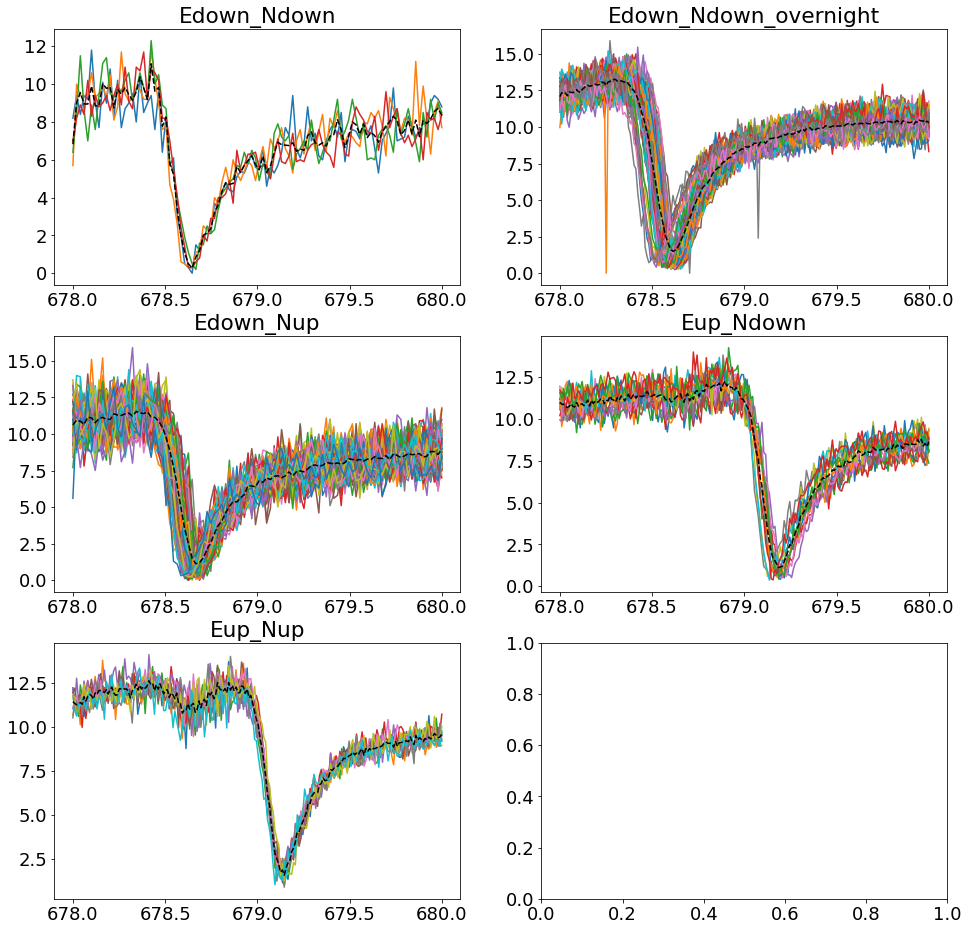

In [4]:
fig, ax = plt.subplots(figsize=[16, 16], ncols=2, nrows=3)
ax = ax.flatten()

for idx, scan_series in enumerate(siv_files):
    
    print(scan_series[0])
    
    siv_freqs = np.loadtxt(siv_path + scan_series[0])
    siv_intensity = np.loadtxt(siv_path + scan_series[1])
    siv_intensity_avg = np.mean(siv_intensity, axis=0)

    siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz

    for scan in siv_intensity:
        ax[idx].plot(siv_freqs, scan)
        
    ax[idx].plot(siv_freqs, siv_intensity_avg, 'k--')
    ax[idx].set_title(scan_series[0].split("/")[0])

Edown_Ndown/linescan_down_down_low-readingtrace_x_18_01_33.txt
Edown_Ndown_overnight/linescan_downe_downn_low-readingtrace_x_10_37_06.txt
Edown_Nup/linescan_downe_upn_low-readingtrace_x_20_49_32.txt


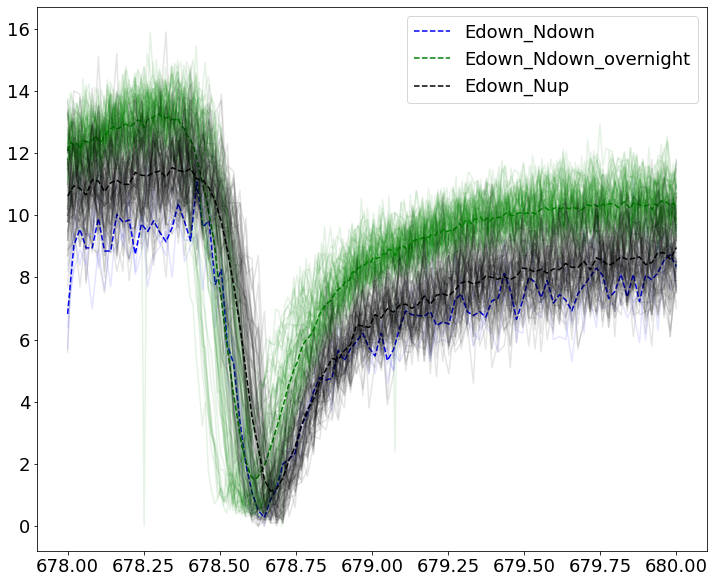

In [5]:
colors = ['b', 'g', 'k']

plt.figure(figsize=[12, 10])
for idx, scan_series in enumerate(siv_files[:3]):
    
    print(scan_series[0])
    
    siv_freqs = np.loadtxt(siv_path + scan_series[0])
    siv_intensity = np.loadtxt(siv_path + scan_series[1])
    siv_intensity_avg = np.mean(siv_intensity, axis=0)

    siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz

    for scan in siv_intensity:
        plt.plot(siv_freqs, scan, c=colors[idx], alpha=0.1)
        
    plt.plot(siv_freqs, siv_intensity_avg, c=colors[idx], ls='--', label=scan_series[0].split("/")[0])

plt.legend()

Eup_Ndown/linescan_upe_downn_low-readingtrace_x_22_45_37.txt
Eup_Nup/linescan_upe_upn_low-readingtrace_x_23_49_04.txt


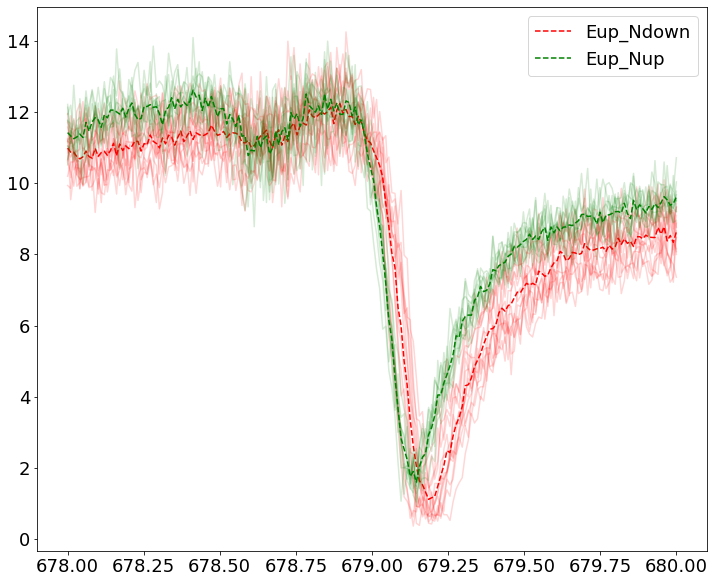

In [6]:
colors = ['r', 'g', 'b']

plt.figure(figsize=[12, 10])
for idx, scan_series in enumerate(siv_files[3:]):
    
    print(scan_series[0])
    
    siv_freqs = np.loadtxt(siv_path + scan_series[0])
    siv_intensity = np.loadtxt(siv_path + scan_series[1])
    siv_intensity_avg = np.mean(siv_intensity, axis=0)

    siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz

    for scan in siv_intensity:
        plt.plot(siv_freqs, scan, c=colors[idx], alpha=0.16)
        
    plt.plot(siv_freqs, siv_intensity_avg, c=colors[idx], ls='--', label=scan_series[0].split("/")[0])

plt.legend()

# E-Down, N-Down

Redchi Mean = 0.8108540693495717, Std = 0.11663043350016328
Filtered out 0 entries
[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 306
    # data points      = 100
    # variables        = 5
    chi-square         = 25.0482867
    reduced chi-square = 0.26366618
    Akaike info crit   = -128.436476
    Bayesian info crit = -115.410625
[[Variables]]
    w_up:      678.531355 +/- 0.01469293 (0.00%) (init = 678.5)
    g_up:      2.77844454 +/- 0.11617384 (4.18%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       610 (fixed)
    k_in:      44.3489682 +/- 10.6564482 (24.03%) (init = 37)
    k_tot:     68.3249385 +/- 12.2550507 (17.94%) (init = 98)
    A:         14.9487781 +/- 1.58820625 (10.62%) (init = 10)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.993
    C(k_tot, A)    =  0.988
    C(k_in, A)     =  0.965
    C(w_up, k_in)  =  0.958
    C(w_up, k_tot) =  0.949
    C(w_up, A)     =  0.915
    

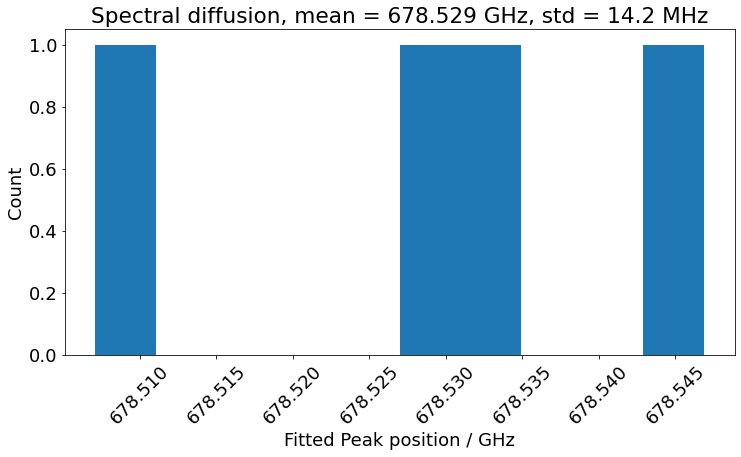

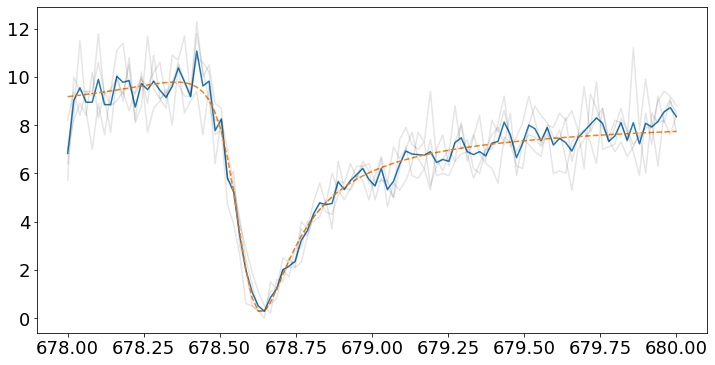

In [7]:
scan_index = 0

siv_freqs = np.loadtxt(siv_path + siv_files[scan_index][0])
siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
siv_intensity = np.loadtxt(siv_path + siv_files[scan_index][1])
siv_intensity_avg = np.mean(siv_intensity, axis=0)
    
###############

w_list_downdown = []
redchi_list = []

for scan_idx, scan in enumerate(siv_intensity):
    params = Parameters()
    params.add_many(
        Parameter('w_up', value=678.5, min=678.2, max=679),
        Parameter('g_up', value=5.6, min=1, max=20),
        Parameter('gamma_up', value=0.05, vary=False),
        Parameter('w_c', value=610, vary=False),
        Parameter('k_in', value=37, min=10, max=356),
        Parameter('k_tot', value=98, min=10, max=356),
        Parameter('A', value=10, min=1, max=20),
        Parameter('B', value=0, vary=False),
    )
    
    down_down_results = single_siv_ref_model.fit(scan, params, w=siv_freqs, method="lbfgsb")
    redchi_list.append(down_down_results.redchi)
    w_list_downdown.append(down_down_results.params["w_up"].value)
    
redchi_list = np.array(redchi_list)
w_list_downdown = np.array(w_list_downdown)

print(f"Redchi Mean = {np.mean(redchi_list)}, Std = {np.std(redchi_list)}")
w_list_downdown = w_list_downdown[redchi_list <= np.mean(redchi_list) + 2 * np.std(redchi_list)]
print(f"Filtered out {len(redchi_list) - len(w_list_downdown)} entries")
    
plt.figure(figsize=[12, 6])
plt.hist(w_list_downdown)
plt.title(f"Spectral diffusion, mean = {np.mean(w_list_downdown):.3f} GHz, std = {1000*np.std(w_list_downdown):.1f} MHz")
plt.gca().set_xticklabels([f"{x:.3f}" for x in plt.gca().get_xticks()], rotation=45)
plt.xlabel("Fitted Peak position / GHz")
plt.ylabel("Count")

###############

params = Parameters()
params.add_many(
    Parameter('w_up', value=678.5, min=678.2, max=679),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=610, vary=False),
    Parameter('k_in', value=37, min=10, max=356),
    Parameter('k_tot', value=98, min=10, max=356),
    Parameter('A', value=10, min=1, max=20),
    Parameter('B', value=0, vary=False),
)

down_down_results = single_siv_ref_model.fit(siv_intensity_avg, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(down_down_results)

plt.figure(figsize=[12, 6])
plt.plot(siv_freqs, siv_intensity_avg)
plt.plot(siv_freqs, single_siv_ref_model.eval(down_down_results.params, w=siv_freqs), '--')
for scan in siv_intensity:
    plt.plot(siv_freqs, scan, c='k', alpha=0.1)

# E-Down, N-Down Overnight

Redchi Mean = 0.27299212984046245, Std = 0.1123327165282004
Filtered out 2 entries
[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 222
    # data points      = 200
    # variables        = 5
    chi-square         = 3.63701576
    reduced chi-square = 0.01865136
    Akaike info crit   = -791.430774
    Bayesian info crit = -774.939187
[[Variables]]
    w_up:      678.446315 +/- 0.00218405 (0.00%) (init = 678.5)
    g_up:      3.25936583 +/- 0.02457121 (0.75%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       610 (fixed)
    k_in:      22.8283116 +/- 0.38298004 (1.68%) (init = 37)
    k_tot:     44.8946618 +/- 0.45071664 (1.00%) (init = 98)
    A:         15.8562918 +/- 0.08384383 (0.53%) (init = 10)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_tot, A)    =  0.978
    C(w_up, g_up)  = -0.959
    C(g_up, k_in)  = -0.928
    C(w_up, k_in)  =  0.923
    C(k_in, k_tot) =  0.917
    C(k_in, A)     =  0.907
    C(g

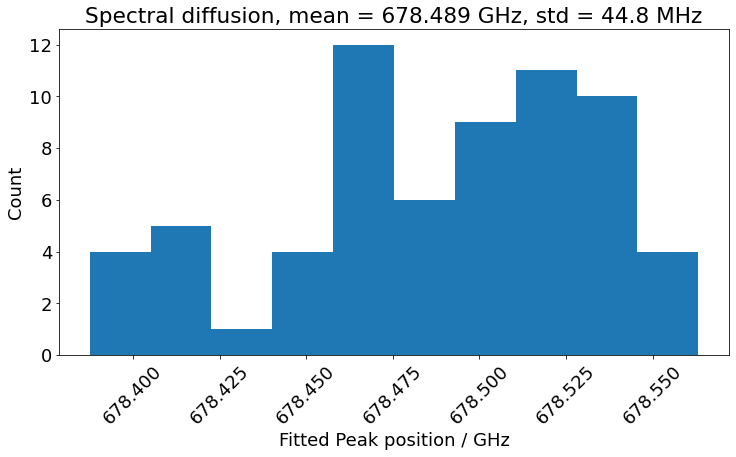

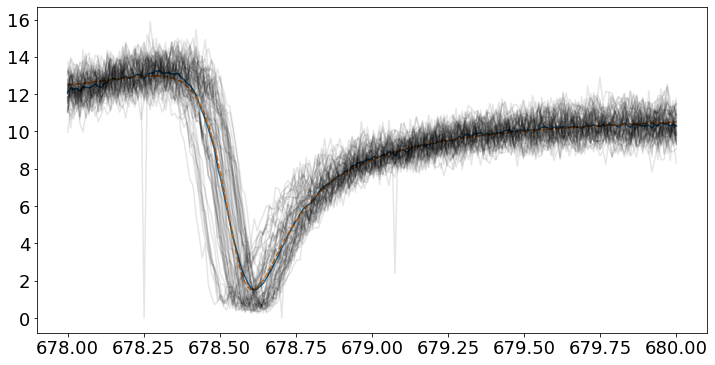

In [8]:
scan_index = 1

siv_freqs = np.loadtxt(siv_path + siv_files[scan_index][0])
siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
siv_intensity = np.loadtxt(siv_path + siv_files[scan_index][1])
siv_intensity_avg = np.mean(siv_intensity, axis=0)
    
###############

w_list_downdown2 = []
redchi_list = []

for scan_idx, scan in enumerate(siv_intensity):
    params = Parameters()
    params.add_many(
        Parameter('w_up', value=678.5, min=678.2, max=679),
        Parameter('g_up', value=5.6, min=1, max=20),
        Parameter('gamma_up', value=0.05, vary=False),
        Parameter('w_c', value=610, vary=False),
        Parameter('k_in', value=37, min=10, max=356),
        Parameter('k_tot', value=98, min=10, max=356),
        Parameter('A', value=10, min=1, max=20),
        Parameter('B', value=0, vary=False),
    )
    
    down_down2_results = single_siv_ref_model.fit(scan, params, w=siv_freqs, method="lbfgsb")
    redchi_list.append(down_down2_results.redchi)
    w_list_downdown2.append(down_down2_results.params["w_up"].value)
    
redchi_list = np.array(redchi_list)
w_list_downdown2 = np.array(w_list_downdown2)

print(f"Redchi Mean = {np.mean(redchi_list)}, Std = {np.std(redchi_list)}")
w_list_downdown2 = w_list_downdown2[redchi_list <= np.mean(redchi_list) + 2 * np.std(redchi_list)]
print(f"Filtered out {len(redchi_list) - len(w_list_downdown2)} entries")
    
plt.figure(figsize=[12, 6])
plt.hist(w_list_downdown2)
plt.title(f"Spectral diffusion, mean = {np.mean(w_list_downdown2):.3f} GHz, std = {1000*np.std(w_list_downdown2):.1f} MHz")
plt.gca().set_xticklabels([f"{x:.3f}" for x in plt.gca().get_xticks()], rotation=45)
plt.xlabel("Fitted Peak position / GHz")
plt.ylabel("Count")

###############

params = Parameters()
params.add_many(
    Parameter('w_up', value=678.5, min=678.2, max=679),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=610, vary=False),
    Parameter('k_in', value=37, min=10, max=356),
    Parameter('k_tot', value=98, min=10, max=356),
    Parameter('A', value=10, min=1, max=20),
    Parameter('B', value=0, vary=False),
)

down_down2_results = single_siv_ref_model.fit(siv_intensity_avg, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(down_down2_results)

plt.figure(figsize=[12, 6])
plt.plot(siv_freqs, siv_intensity_avg)
plt.plot(siv_freqs, single_siv_ref_model.eval(down_down2_results.params, w=siv_freqs), '--')
for scan in siv_intensity:
    plt.plot(siv_freqs, scan, c='k', alpha=0.1)

# E-Down, N-Up

Redchi Mean = 0.9114437796471442, Std = 0.14753631566801376
Filtered out 2 entries
[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 192
    # data points      = 100
    # variables        = 5
    chi-square         = 1.95360364
    reduced chi-square = 0.02056425
    Akaike info crit   = -383.549450
    Bayesian info crit = -370.523599
[[Variables]]
    w_up:      678.507185 +/- 0.00319190 (0.00%) (init = 678.5)
    g_up:      3.24907829 +/- 0.03672230 (1.13%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       610 (fixed)
    k_in:      25.4296766 +/- 0.65218594 (2.56%) (init = 37)
    k_tot:     51.2560987 +/- 0.77677961 (1.52%) (init = 98)
    A:         14.5240695 +/- 0.14108828 (0.97%) (init = 10)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_tot, A)    =  0.979
    C(w_up, g_up)  = -0.945
    C(k_in, A)     =  0.919
    C(g_up, k_in)  = -0.917
    C(w_up, k_in)  =  0.912
    C(k_in, k_tot) =  0.905
    C(g

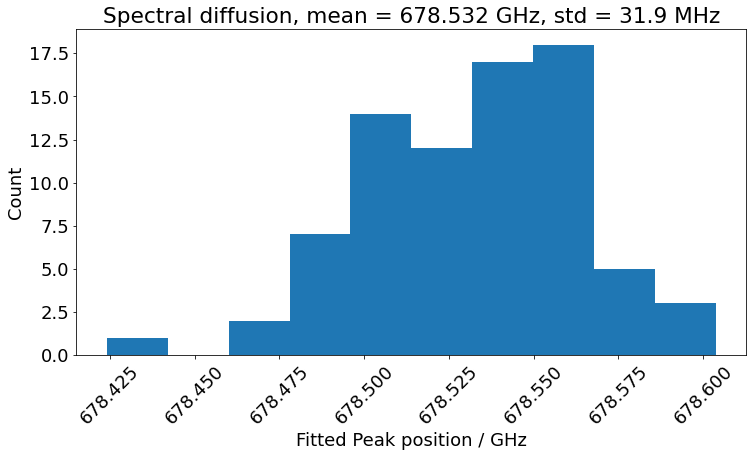

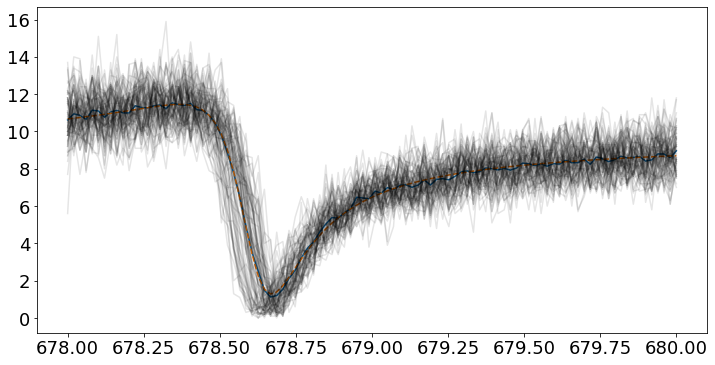

In [9]:
scan_index = 2

siv_freqs = np.loadtxt(siv_path + siv_files[scan_index][0])
siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
siv_intensity = np.loadtxt(siv_path + siv_files[scan_index][1])
siv_intensity_avg = np.mean(siv_intensity, axis=0)
    
###############

w_list_downup = []
redchi_list = []

for scan_idx, scan in enumerate(siv_intensity):
    params = Parameters()
    params.add_many(
        Parameter('w_up', value=678.5, min=678.2, max=679),
        Parameter('g_up', value=5.6, min=1, max=20),
        Parameter('gamma_up', value=0.05, vary=False),
        Parameter('w_c', value=610, vary=False),
        Parameter('k_in', value=37, min=10, max=356),
        Parameter('k_tot', value=98, min=10, max=356),
        Parameter('A', value=10, min=1, max=20),
        Parameter('B', value=0, vary=False),
    )
    
    down_up_results = single_siv_ref_model.fit(scan, params, w=siv_freqs, method="lbfgsb")
    redchi_list.append(down_up_results.redchi)
    w_list_downup.append(down_up_results.params["w_up"].value)
    
redchi_list = np.array(redchi_list)
w_list_downup = np.array(w_list_downup)

print(f"Redchi Mean = {np.mean(redchi_list)}, Std = {np.std(redchi_list)}")
w_list_downup = w_list_downup[redchi_list <= np.mean(redchi_list) + 2 * np.std(redchi_list)]
print(f"Filtered out {len(redchi_list) - len(w_list_downup)} entries")
    
plt.figure(figsize=[12, 6])
plt.hist(w_list_downup)
plt.title(f"Spectral diffusion, mean = {np.mean(w_list_downup):.3f} GHz, std = {1000*np.std(w_list_downup):.1f} MHz")
plt.gca().set_xticklabels([f"{x:.3f}" for x in plt.gca().get_xticks()], rotation=45)
plt.xlabel("Fitted Peak position / GHz")
plt.ylabel("Count")

###############

params = Parameters()
params.add_many(
    Parameter('w_up', value=678.5, min=678.2, max=679),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=610, vary=False),
    Parameter('k_in', value=37, min=10, max=356),
    Parameter('k_tot', value=98, min=10, max=356),
    Parameter('A', value=10, min=1, max=20),
    Parameter('B', value=0, vary=False),
)

down_up_results = single_siv_ref_model.fit(siv_intensity_avg, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(down_up_results)

plt.figure(figsize=[12, 6])
plt.plot(siv_freqs, siv_intensity_avg)
plt.plot(siv_freqs, single_siv_ref_model.eval(down_up_results.params, w=siv_freqs), '--')
for scan in siv_intensity:
    plt.plot(siv_freqs, scan, c='k', alpha=0.1)

# E-Up, N-Down

Redchi Mean = 0.25699253290087937, Std = 0.02604892360990419
Filtered out 0 entries
[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 246
    # data points      = 200
    # variables        = 5
    chi-square         = 7.35673865
    reduced chi-square = 0.03772686
    Akaike info crit   = -650.540130
    Bayesian info crit = -634.048543
[[Variables]]
    w_up:      679.034756 +/- 0.00281457 (0.00%) (init = 679.2)
    g_up:      3.15871799 +/- 0.03180594 (1.01%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       610 (fixed)
    k_in:      26.5258254 +/- 0.68416523 (2.58%) (init = 37)
    k_tot:     50.3559675 +/- 0.79666525 (1.58%) (init = 98)
    A:         15.2923392 +/- 0.14664740 (0.96%) (init = 10)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_tot, A)    =  0.988
    C(w_up, g_up)  = -0.939
    C(k_in, A)     =  0.922
    C(g_up, k_in)  = -0.920
    C(w_up, k_in)  =  0.920
    C(k_in, k_tot) =  0.919
    C(

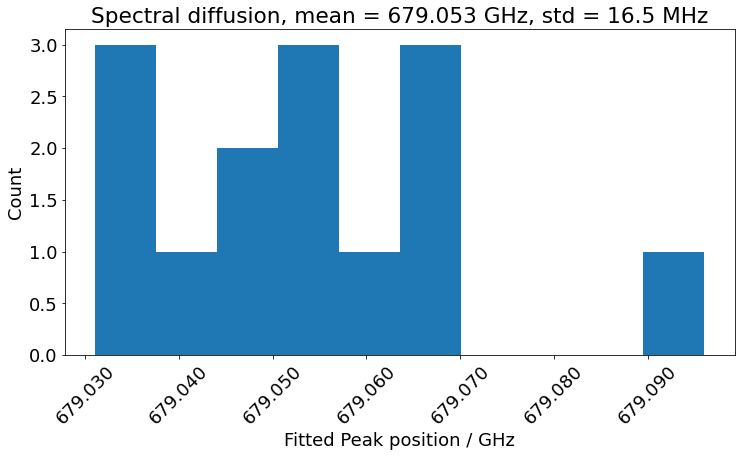

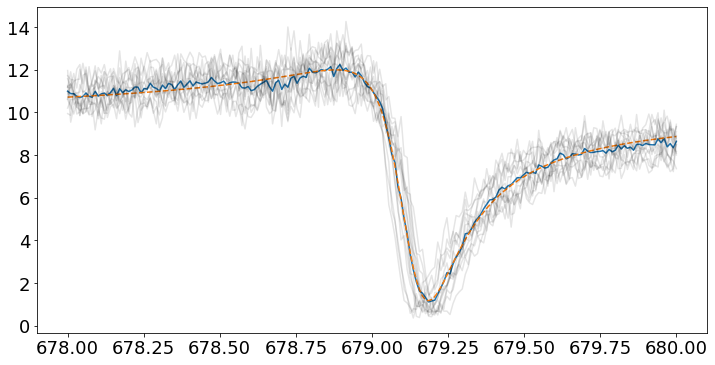

In [10]:
scan_index = 3

siv_freqs = np.loadtxt(siv_path + siv_files[scan_index][0])
siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
siv_intensity = np.loadtxt(siv_path + siv_files[scan_index][1])
siv_intensity_avg = np.mean(siv_intensity, axis=0)
    
###############

w_list_updown = []
redchi_list = []

for scan_idx, scan in enumerate(siv_intensity):
    params = Parameters()
    params.add_many(
        Parameter('w_up', value=679.2, min=678.8, max=679.5),
        Parameter('g_up', value=5.6, min=1, max=20),
        Parameter('gamma_up', value=0.05, vary=False),
        Parameter('w_c', value=610, vary=False),
        Parameter('k_in', value=37, min=10, max=356),
        Parameter('k_tot', value=98, min=10, max=356),
        Parameter('A', value=10, min=1, max=20),
        Parameter('B', value=0, vary=False),
    )
    
    up_down_results = single_siv_ref_model.fit(scan, params, w=siv_freqs, method="lbfgsb")
    redchi_list.append(up_down_results.redchi)
    w_list_updown.append(up_down_results.params["w_up"].value)
    
redchi_list = np.array(redchi_list)
w_list_updown = np.array(w_list_updown)

print(f"Redchi Mean = {np.mean(redchi_list)}, Std = {np.std(redchi_list)}")
w_list_updown = w_list_updown[redchi_list <= np.mean(redchi_list) + 2 * np.std(redchi_list)]
print(f"Filtered out {len(redchi_list) - len(w_list_updown)} entries")
    
plt.figure(figsize=[12, 6])
plt.hist(w_list_updown)
plt.title(f"Spectral diffusion, mean = {np.mean(w_list_updown):.3f} GHz, std = {1000*np.std(w_list_updown):.1f} MHz")
plt.gca().set_xticklabels([f"{x:.3f}" for x in plt.gca().get_xticks()], rotation=45)
plt.xlabel("Fitted Peak position / GHz")
plt.ylabel("Count")

###############

params = Parameters()
params.add_many(
    Parameter('w_up', value=679.2, min=678.8, max=679.5),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=610, vary=False),
    Parameter('k_in', value=37, min=10, max=356),
    Parameter('k_tot', value=98, min=10, max=356),
    Parameter('A', value=10, min=1, max=20),
    Parameter('B', value=0, vary=False),
)

up_down_results = single_siv_ref_model.fit(siv_intensity_avg, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(up_down_results)

plt.figure(figsize=[12, 6])
plt.plot(siv_freqs, siv_intensity_avg)
plt.plot(siv_freqs, single_siv_ref_model.eval(up_down_results.params, w=siv_freqs), '--')
for scan in siv_intensity:
    plt.plot(siv_freqs, scan, c='k', alpha=0.1)

# E-Up, N-Up

Redchi Mean = 0.5972311239015807, Std = 0.1387139534772342
Filtered out 0 entries
[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 510
    # data points      = 200
    # variables        = 5
    chi-square         = 32.9780837
    reduced chi-square = 0.16911838
    Akaike info crit   = -350.494831
    Bayesian info crit = -334.003244
[[Variables]]
    w_up:      678.991888 +/- 0.00653620 (0.00%) (init = 679.2)
    g_up:      3.10418465 +/- 0.07875944 (2.54%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       610 (fixed)
    k_in:      21.9281057 +/- 1.24154293 (5.66%) (init = 29)
    k_tot:     44.1090022 +/- 1.54074487 (3.49%) (init = 46)
    A:         15.0571910 +/- 0.27788046 (1.85%) (init = 10)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_tot, A)    =  0.984
    C(w_up, g_up)  = -0.959
    C(g_up, k_in)  = -0.945
    C(k_in, A)     =  0.932
    C(w_up, k_in)  =  0.931
    C(k_in, k_tot) =  0.915
    C(g_

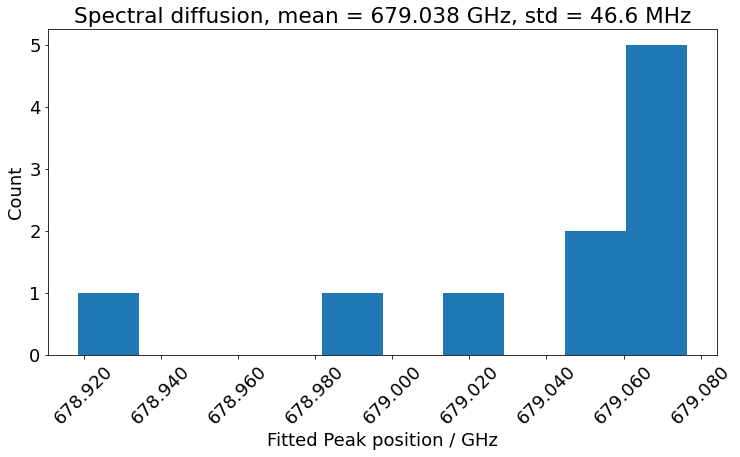

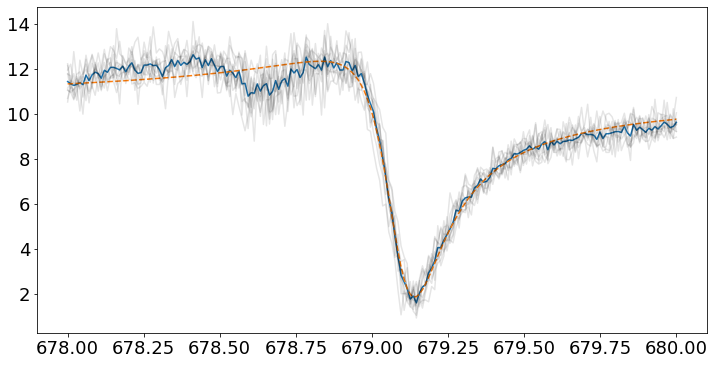

In [11]:
scan_index = 4

siv_freqs = np.loadtxt(siv_path + siv_files[scan_index][0])
siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
siv_intensity = np.loadtxt(siv_path + siv_files[scan_index][1])
siv_intensity_avg = np.mean(siv_intensity, axis=0)
    
###############

w_list_upup = []
redchi_list = []

for scan_idx, scan in enumerate(siv_intensity):
    params = Parameters()
    params.add_many(
        Parameter('w_up', value=679.2, min=678.8, max=679.5),
        Parameter('g_up', value=5.6, min=1, max=20),
        Parameter('gamma_up', value=0.05, vary=False),
        Parameter('w_c', value=610, vary=False),
        Parameter('k_in', value=37, min=10, max=356),
        Parameter('k_tot', value=98, min=10, max=356),
        Parameter('A', value=10, min=1, max=20),
        Parameter('B', value=0, vary=False),
    )
    
    up_up_results = single_siv_ref_model.fit(scan, params, w=siv_freqs, method="lbfgsb")
    redchi_list.append(up_up_results.redchi)
    w_list_upup.append(up_up_results.params["w_up"].value)
    
redchi_list = np.array(redchi_list)
w_list_upup = np.array(w_list_upup)

print(f"Redchi Mean = {np.mean(redchi_list)}, Std = {np.std(redchi_list)}")
w_list_upup = w_list_upup[redchi_list <= np.mean(redchi_list) + 2 * np.std(redchi_list)]
print(f"Filtered out {len(redchi_list) - len(w_list_upup)} entries")
    
plt.figure(figsize=[12, 6])
plt.hist(w_list_upup)
plt.title(f"Spectral diffusion, mean = {np.mean(w_list_upup):.3f} GHz, std = {1000*np.std(w_list_upup):.1f} MHz")
plt.gca().set_xticklabels([f"{x:.3f}" for x in plt.gca().get_xticks()], rotation=45)
plt.xlabel("Fitted Peak position / GHz")
plt.ylabel("Count")

###############

params = Parameters()
params.add_many(
    Parameter('w_up', value=679.2, min=678.8, max=679.5),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=610, vary=False),
    Parameter('k_in', value=29, min=10, max=356),
    Parameter('k_tot', value=46, min=10, max=356),
    Parameter('A', value=10, min=1, max=20),
    Parameter('B', value=0, vary=False),
)

up_up_results = single_siv_ref_model.fit(siv_intensity_avg, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(up_up_results)

plt.figure(figsize=[12, 6])
plt.plot(siv_freqs, siv_intensity_avg)
plt.plot(siv_freqs, single_siv_ref_model.eval(up_up_results.params, w=siv_freqs), '--')
for scan in siv_intensity:
    plt.plot(siv_freqs, scan, c='k', alpha=0.1)

# Combined Fits + Spectral Diffusion

In [12]:
# Consider using diffusion to blur the output
spectral_diffusion = 0.03

# Sample within 2 stdev
delta_lst = np.linspace(-2*spectral_diffusion, 2*spectral_diffusion, 21)

# Weigh using a normalized Gaussian
normal_pdf = np.array([norm.pdf(delta, 0, spectral_diffusion) for delta in delta_lst])
normal_pdf /= sum(normal_pdf) 

def get_val_from_model(params, scan_idx, model, w):   
    w_c = params[f"w_c"]
    k_in = params["k_in"]
    k_tot = params["k_tot"]
    B = params["B"]
    gamma_up = params[f"gamma_up"]
    
    A = params[f"A_scan{scan_idx}"]
    w_up = params[f"w_up_scan{scan_idx}"]
    g_up = params[f"g_up_scan{scan_idx}"]
    args = [w_up, g_up, gamma_up, w_c, k_in, k_tot, A, B]
    
    # Use diffusion to blur the output
    diffused_output = np.array([model(w + delta, *args) for delta in delta_lst])
    convolved_output = np.sum([diffused_output[i] * normal_pdf[i] for i in range(len(normal_pdf))], axis=0)
    
    return convolved_output
#     return model(w, *args)

def objective(params, freqs_lst, data_lst, model_list):
    residuals_lst = np.array([])
    
    for scan_idx in range(len(data_lst)):
        
        freqs = freqs_lst[scan_idx]
        data = data_lst[scan_idx]
        model = model_list[scan_idx]

        residual = data - get_val_from_model(params, scan_idx, model, freqs)
        residuals_lst = np.append(residuals_lst, residual)

    return residuals_lst

def collect_folder_data(folder_idx):

    siv_freqs = np.loadtxt(siv_path + siv_files[folder_idx][0])
    siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
    siv_intensity = np.loadtxt(siv_path + siv_files[folder_idx][1])
    siv_intensity_avg = np.mean(siv_intensity, axis=0)

    return siv_freqs, siv_intensity_avg

def fit_combined_data(fit_params, objective, model_list, w_up_guesses):
            
    siv_freqs_list = []
    siv_data_list = []

    for scan_idx in range(len(siv_files)):
        
        siv_freqs, siv_data = collect_folder_data(scan_idx)
        siv_freqs_list.append(siv_freqs)
        siv_data_list.append(siv_data)
        
        w_up_guess = w_up_guesses[scan_idx]
        fit_params.add(f"w_up_scan{scan_idx}", value=w_up_guess, min=w_up_guess-1, max=w_up_guess+1)
        fit_params.add(f"g_up_scan{scan_idx}", value=5.6, min=1, max=20)
        fit_params.add(f"A_scan{scan_idx}", value=10, min=1, max=20)

    out = lmfit.minimize(objective, fit_params, args=(siv_freqs_list, siv_data_list, model_list), method="lbfgsb")
    return out

## Vary k_tot

In [13]:
fit_params = Parameters()
fit_params.add("w_c", value=610, vary=False)#min=0, max=800)
fit_params.add("gamma_up", value=0.05, vary=False)
fit_params.add('k_in', value=99, min=10, max=356)
fit_params.add("k_tot", value=130, min=10, max=356)
fit_params.add("B", value=0, vary=False)

model_list = [single_siv_ref] * len(siv_files)
w_up_guesses = [678.529, 678.489, 678.532, 679.053, 679.031]

combined_results_vary_ktot = fit_combined_data(fit_params, objective, model_list, w_up_guesses)
lmfit.report_fit(combined_results_vary_ktot)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 5184
    # data points      = 800
    # variables        = 17
    chi-square         = 79.3208734
    reduced chi-square = 0.10130380
    Akaike info crit   = -1814.88833
    Bayesian info crit = -1735.24993
[[Variables]]
    w_c:         610 (fixed)
    gamma_up:    0.05 (fixed)
    k_in:        31.1523726 +/- 0.94224183 (3.02%) (init = 99)
    k_tot:       54.5764432 +/- 1.06985407 (1.96%) (init = 130)
    B:           0 (fixed)
    w_up_scan0:  678.505518 +/- 0.00393002 (0.00%) (init = 678.529)
    g_up_scan0:  2.99084277 +/- 0.04335109 (1.45%) (init = 5.6)
    A_scan0:     13.2209138 +/- 0.16799694 (1.27%) (init = 10)
    w_up_scan1:  678.476965 +/- 0.00308398 (0.00%) (init = 678.489)
    g_up_scan1:  2.89203731 +/- 0.03446788 (1.19%) (init = 5.6)
    A_scan1:     17.7380392 +/- 0.21470104 (1.21%) (init = 10)
    w_up_scan2:  678.528640 +/- 0.00388195 (0.00%) (init = 678.532)
    g_up_scan2:  3.08652889 +

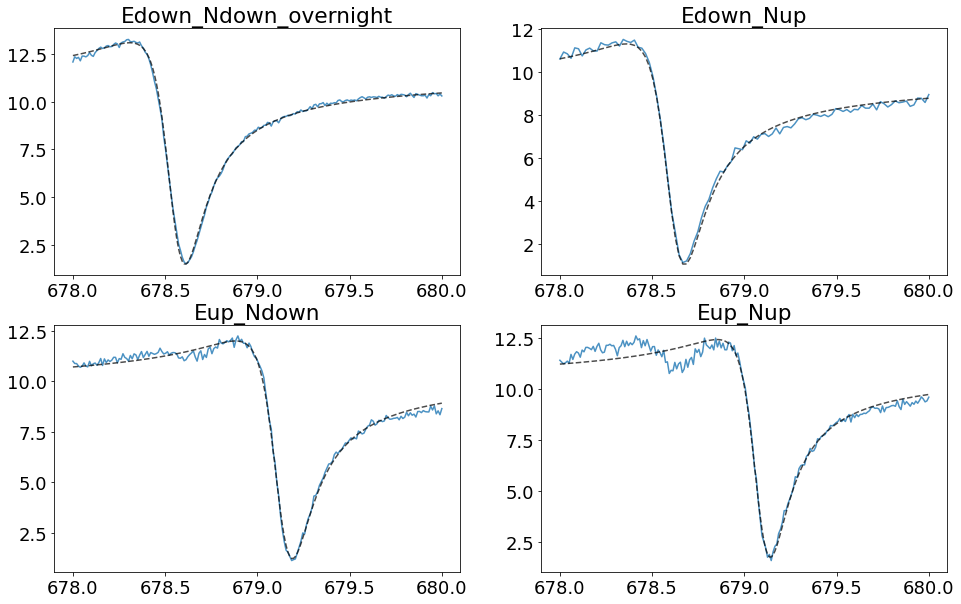

In [14]:
fig, ax = plt.subplots(figsize=[16, 10], ncols=2, nrows=2)
ax = ax.flatten()

# Ignore the first scan as it was shorter
for scan_idx, filename in enumerate(siv_files):
        if scan_idx == 0: continue    

        siv_freqs, siv_data = collect_folder_data(scan_idx)
        ax[scan_idx-1].plot(siv_freqs, siv_data, alpha=0.8)
        ax[scan_idx-1].plot(siv_freqs, get_val_from_model(combined_results_vary_ktot.params, scan_idx, 
                                           model_list[scan_idx], siv_freqs), c='k', ls='--', alpha=0.7)
        ax[scan_idx-1].set_title(filename[0].split("/")[0])

## Fix k_tot

In [15]:
fit_params = Parameters()
fit_params.add("w_c", value=610, vary=False) #min=0, max=800)
fit_params.add("gamma_up", value=0.05, vary=False)
fit_params.add('k_in', value=63, min=10, max=356)
fit_params.add("k_tot", value=98.6, vary=False)
fit_params.add("B", value=0, vary=False)

model_list = [single_siv_ref] * len(siv_files)
w_up_guesses = [678.529, 678.489, 678.532, 679.053, 679.031]

combined_results_fix_ktot = fit_combined_data(fit_params, objective, model_list, w_up_guesses)
lmfit.report_fit(combined_results_fix_ktot)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 2924
    # data points      = 800
    # variables        = 16
    chi-square         = 203.048564
    reduced chi-square = 0.25899052
    Akaike info crit   = -1064.93324
    Bayesian info crit = -989.979448
[[Variables]]
    w_c:         610 (fixed)
    gamma_up:    0.05 (fixed)
    k_in:        77.9502692 +/- 0.16482082 (0.21%) (init = 63)
    k_tot:       98.6 (fixed)
    B:           0 (fixed)
    w_up_scan0:  678.553591 +/- 0.00579432 (0.00%) (init = 678.529)
    g_up_scan0:  3.36743780 +/- 0.08468790 (2.51%) (init = 5.6)
    A_scan0:     15.2795761 +/- 0.13010956 (0.85%) (init = 10)
    w_up_scan1:  678.527783 +/- 0.00359581 (0.00%) (init = 678.489)
    g_up_scan1:  3.22700922 +/- 0.06230144 (1.93%) (init = 5.6)
    A_scan1:     20.0000000 +/- 1.3360e-05 (0.00%) (init = 10)
    w_up_scan2:  678.559776 +/- 0.00612385 (0.00%) (init = 678.532)
    g_up_scan2:  3.76232492 +/- 0.08028271 (2.13%) (init = 5.6)

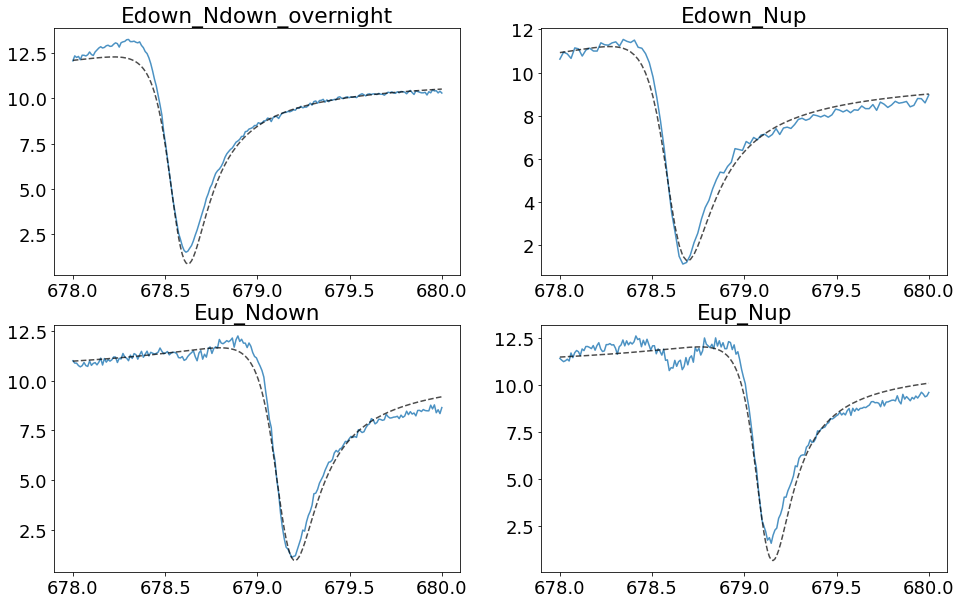

In [16]:
fig, ax = plt.subplots(figsize=[16, 10], ncols=2, nrows=2)
ax = ax.flatten()

# Ignore the first scan as it was shorter
for scan_idx, filename in enumerate(siv_files):
        if scan_idx == 0: continue    

        siv_freqs, siv_data = collect_folder_data(scan_idx)
        ax[scan_idx-1].plot(siv_freqs, siv_data, alpha=0.8)
        ax[scan_idx-1].plot(siv_freqs, get_val_from_model(combined_results_fix_ktot.params, scan_idx, 
                                           model_list[scan_idx], siv_freqs), c='k', ls='--', alpha=0.7)
        ax[scan_idx-1].set_title(filename[0].split("/")[0])

# Diffusion

[  0.     -39.9971   2.6473 524.2656 509.5687]
[14.1966 44.8055 31.9382 16.5404 46.6143]


Text(0, 0.5, 'Diffusion Stdev / MHz')

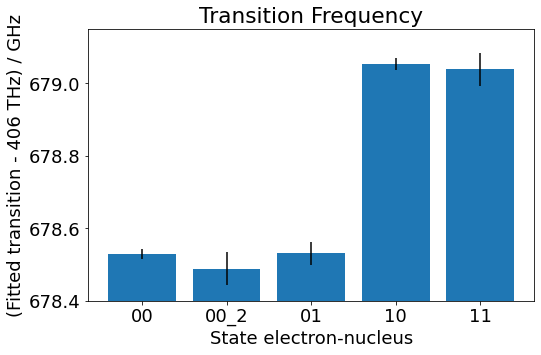

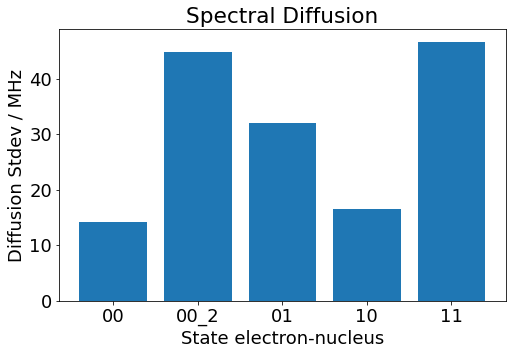

In [17]:
w_list = [w_list_downdown, w_list_downdown2, w_list_downup, w_list_updown, w_list_upup]
state_list = ["00", "00_2", "01", "10", "11"]

means = np.array([np.mean(w) for w in w_list])
stdevs = np.array([np.std(w) for w in w_list])

print((means - means[0]) * 1000)
print(stdevs * 1000)

plt.bar(state_list, means, yerr=stdevs)
plt.title("Transition Frequency")
plt.ylim(678.4, 679.15)
plt.xlabel("State electron-nucleus")
plt.ylabel("(Fitted transition - 406 THz) / GHz")

plt.figure()
plt.title("Spectral Diffusion")
plt.bar(state_list, np.array([np.std(w) for w in w_list]) * 1000)
plt.xlabel("State electron-nucleus")
plt.ylabel("Diffusion Stdev / MHz")

In [18]:
print(means)
print((means[2] - means[0]) * 1000)
print((means[2] - means[1]) * 1000)
print((means[4] - means[3]) * 1000)

[678.5289 678.4889 678.5315 679.0531 679.0384]
2.647341631927702
42.64447565003593
-14.696916703087481


# Compute Phase difference

## Using fits with k_tot varying

In [19]:
# Construct Cavity objects from the fitted parameters
cavity_objects = []

for index in range(1, 5):
    c = Cavity({"w_c" : combined_results_vary_ktot.params["w_c"], 
                "k_in" : combined_results_vary_ktot.params["k_in"], 
                "k_tot" : combined_results_vary_ktot.params["k_tot"]}, 
               {"w_up" : combined_results_vary_ktot.params[f"w_up_scan{index}"], 
                "g_up" :combined_results_vary_ktot.params[f"g_up_scan{index}"], 
                "gamma_up" : combined_results_vary_ktot.params["gamma_up"]})
    
    cavity_objects.append(c)

Text(0.5, 0, 'Frequency / GHz')

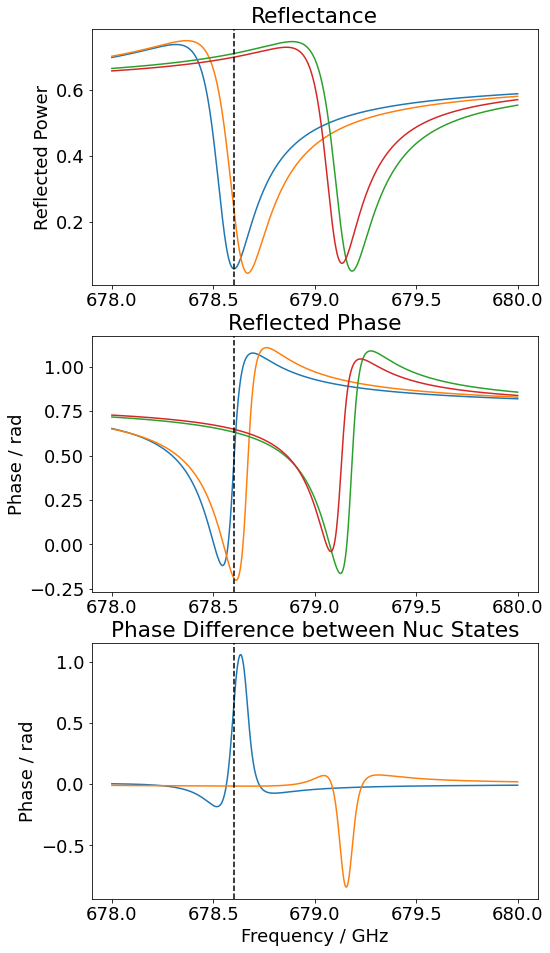

In [20]:
w_arr = np.linspace(678, 680, 1000, )
fig, ax = plt.subplots(nrows=3, figsize=[8, 16])
ax = ax.flatten()

# Plot reflectance and reflected phase for 4 states
for c in cavity_objects:
    ax[0].plot(w_arr, c.reflectance(w_arr, 1))
    ax[1].plot(w_arr, c.reflected_phase(w_arr, 1))
    
# Plot difference in phase between each pair of nuclear states
ax[2].plot(w_arr, cavity_objects[0].reflected_phase(w_arr, 1) - cavity_objects[1].reflected_phase(w_arr, 1))
ax[2].plot(w_arr, cavity_objects[2].reflected_phase(w_arr, 1) - cavity_objects[3].reflected_phase(w_arr, 1))

laser_freq = 678.6
for ax_idx in range(3):
    ax[ax_idx].axvline(laser_freq, c='k', ls='--')

ax[0].set_title("Reflectance")
ax[1].set_title("Reflected Phase")
ax[2].set_title("Phase Difference between Nuc States")
ax[0].set_ylabel("Reflected Power")
ax[1].set_ylabel("Phase / rad")
ax[2].set_ylabel("Phase / rad")
ax[2].set_xlabel("Frequency / GHz")

In [21]:
w_up_vals = [combined_results_vary_ktot.params[f"w_up_scan{i}"].value for i in range(5)]

print(w_up_vals)
print((w_up_vals[2] - w_up_vals[0]) * 1000) # Sep between edown_ndown and nup
print((w_up_vals[2] - w_up_vals[1]) * 1000) # Sep between edown_ndown (overnight) and nup 
print((w_up_vals[4] - w_up_vals[3]) * 1000) # Sep between eup_ndown and nup

[678.5055178619654, 678.4769652393143, 678.528639768122, 679.0499937981037, 679.0229879347881]
23.121906156688965
51.67452880778001
-27.00586331559407


## Using fits with k_tot fixed

In [22]:
# Construct Cavity objects from the fitted parameters
cavity_objects_k_fixed = []

for index in range(1, 5):
    c = Cavity({"w_c" : combined_results_fix_ktot.params["w_c"], 
                "k_in" : combined_results_fix_ktot.params["k_in"], 
                "k_tot" : combined_results_fix_ktot.params["k_tot"]}, 
               {"w_up" : combined_results_fix_ktot.params[f"w_up_scan{index}"], 
                "g_up" :combined_results_fix_ktot.params[f"g_up_scan{index}"], 
                "gamma_up" : combined_results_fix_ktot.params["gamma_up"]})
    
    cavity_objects_k_fixed.append(c)

Text(0.5, 1.0, 'Phase Difference between Nuc States')

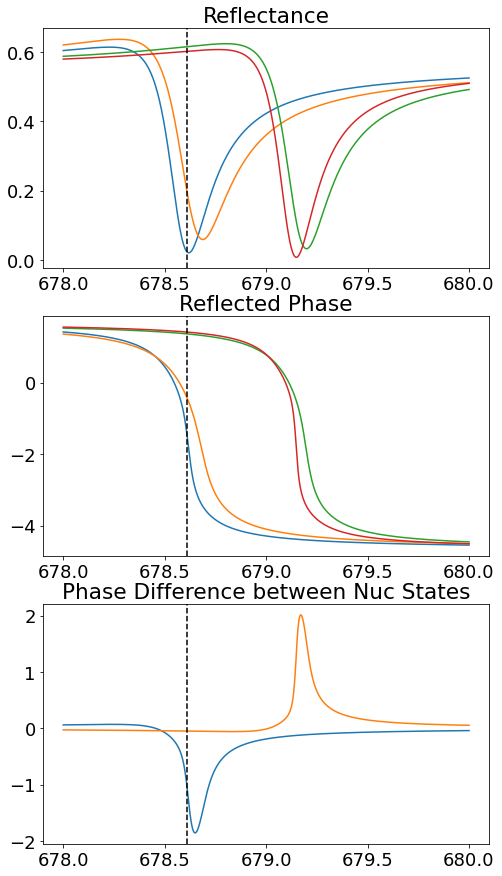

In [23]:
w_arr = np.linspace(678, 680, 1000)
fig, ax = plt.subplots(nrows=3, figsize=[8, 15])
ax = ax.flatten()

# Plot reflectance and reflected phase for 4 states
for c in cavity_objects_k_fixed:
    ax[0].plot(w_arr, c.reflectance(w_arr, 1))
    phase = c.reflected_phase(w_arr, 1)
    phase = np.unwrap(phase)
    ax[1].plot(w_arr, phase)
    
# Plot difference in phase between each pair of nuclear states
phase_diff1 = np.unwrap(cavity_objects_k_fixed[0].reflected_phase(w_arr, 1) - cavity_objects_k_fixed[1].reflected_phase(w_arr, 1))
phase_diff2 = np.unwrap(cavity_objects_k_fixed[2].reflected_phase(w_arr, 1) - cavity_objects_k_fixed[3].reflected_phase(w_arr, 1))
ax[2].plot(w_arr, phase_diff1)
ax[2].plot(w_arr, phase_diff2)

laser_freq = 678.61
for ax_idx in range(3):
    ax[ax_idx].axvline(laser_freq, c='k', ls='--')

ax[1].set_ylim
ax[0].set_title("Reflectance")
ax[1].set_title("Reflected Phase")
ax[2].set_title("Phase Difference between Nuc States")